In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

from scipy.optimize import minimize

from gpcg import GPCGSolver
from gpcg import make_1d_signal, make_shepp_logan_image, build_1d_first_order_grad, build_2d_first_order_grad

# Toy problem

In [2]:
# Parameters for the problem
n = 100
reg_lambda = 1e2
blur_sigma = 1.5
noise_sigma = 0.2

# Make test signal
dom = np.linspace(0, 1, 100)
x = make_1d_signal( dom ) + np.sin(5*dom)

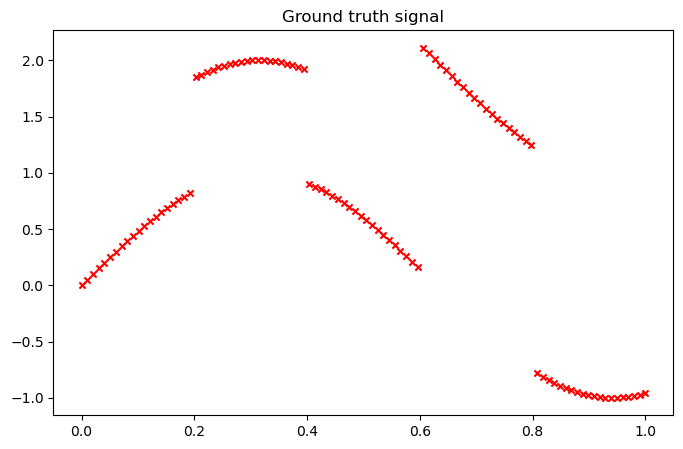

In [3]:
plt.figure(figsize=(8,5))
plt.scatter(dom, x, marker="x", color="red", s=20.0)
plt.title("Ground truth signal")
plt.show()

In [4]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
rmat = build_1d_first_order_grad(n, boundary="zero")
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [5]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(x) + noise_sigma*np.random.randn(n)

# Get solution via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

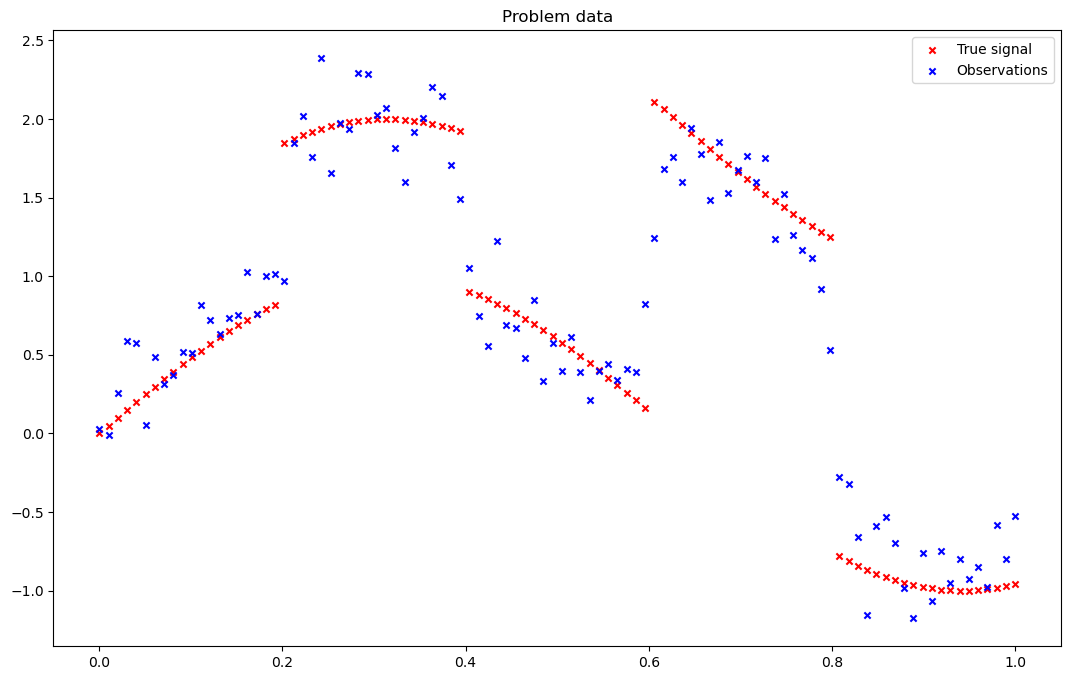

In [6]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.legend()
plt.title("Problem data")
plt.show()

# Solve the least squares problem

In [61]:
Fw = (1/noise_sigma)*F
yw = (1/noise_sigma)*y

In [66]:
reg_lambda = 100
R = build_1d_first_order_grad(n, boundary="none")
R_linop = aslinearoperator(R)
R = R.toarray()
Q = (Fw.T @ Fw) + reg_lambda*(R_linop.T @ R_linop)
scipy_cg_sol, _ = scipy_cg(Q, Fw.T @ yw , maxiter=1e5)

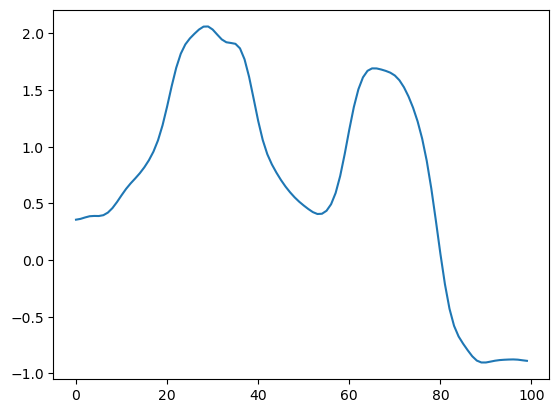

In [67]:
plt.plot(scipy_cg_sol)

In [75]:
# Get a matrix whose columns are a basis for the nullspace of A
from scipy.linalg import null_space
W = null_space(R)

# Get QR factorization of R^T
Q1, R1 = np.linalg.qr(R.T)

# Get QR factorization of FW
Q2, R2 = np.linalg.qr(Fw @ W)

# Define oblique projector via matvecs
def _matvec(v):

    _tmp = np.linalg.solve(R1.T, v)
    _tmp = Q1 @ _tmp

    _tmp2 = Q2.T @ (Fw @ _tmp)
    _tmp2 = np.linalg.solve( R2, _tmp2 )
    _tmp2 = W @ _tmp2

    result = _tmp - _tmp2

    return result


def _rmatvec(v):

    tmp = W.T @ v
    tmp = np.linalg.solve(R2.T, tmp)
    tmp = Q2 @ tmp
    tmp = Fw.T @ tmp

    tmp2 = v - tmp

    tmp3 = Q1.T @ tmp2
    tmp3 = np.linalg.solve( R1, tmp3)

    result = tmp3

    return result


R_projector = LinearOperator(shape=(n,n - W.shape[1]), dtype=np.float32, matvec=_matvec, rmatvec=_rmatvec)

# Get the part in the nullspace
tmp = Q2.T @ yw
tmp = np.linalg.solve(R2, tmp)
tmp = W @ tmp
x_null = tmp

# Solve least squares problem
Ftilde = Fw @ R_projector
Q = (Ftilde.T @ Ftilde) + reg_lambda*aslinearoperator(np.eye(n-1))
x_lsq, nits = scipy_cg( Q, Ftilde.T @ yw, maxiter=200 )

# Build solution
x_sol = (R_projector @ x_lsq) + x_null
print(nits)

NotImplementedError: rmatvec is not defined

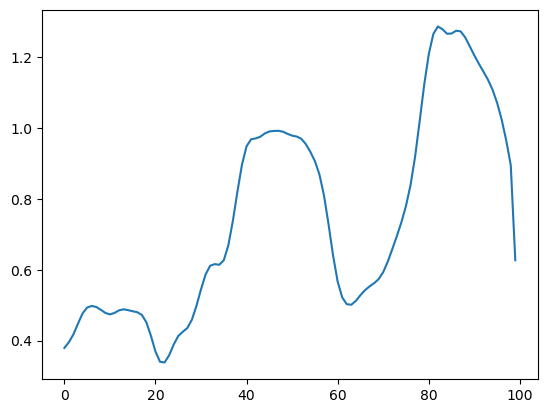

In [76]:
plt.plot(x_sol)
plt.show()

In [50]:
R_projector @ np.ones(n-1)

array([-49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5,
       -40.5, -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5,
       -31.5, -30.5, -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5,
       -22.5, -21.5, -20.5, -19.5, -18.5, -17.5, -16.5, -15.5, -14.5,
       -13.5, -12.5, -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,
        -4.5,  -3.5,  -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,
         4.5,   5.5,   6.5,   7.5,   8.5,   9.5,  10.5,  11.5,  12.5,
        13.5,  14.5,  15.5,  16.5,  17.5,  18.5,  19.5,  20.5,  21.5,
        22.5,  23.5,  24.5,  25.5,  26.5,  27.5,  28.5,  29.5,  30.5,
        31.5,  32.5,  33.5,  34.5,  35.5,  36.5,  37.5,  38.5,  39.5,
        40.5,  41.5,  42.5,  43.5,  44.5,  45.5,  46.5,  47.5,  48.5,
        49.5])

In [51]:
R_projector.T @ np.ones(n)

array([-9.29266758e-16, -1.05326469e-15, -1.09685297e-15, -1.05079216e-15,
       -5.30779323e-16, -7.72459629e-16, -5.86645820e-16, -8.57982499e-16,
       -2.88976751e-16, -2.37973913e-16, -4.03641860e-16, -1.37209473e-16,
       -1.18074769e-16, -1.02684164e-16, -9.01201576e-17, -2.89075856e-16,
       -2.57393059e-16, -1.99835016e-17, -1.80196920e-17, -1.63318943e-17,
        1.97300282e-16,  3.92889627e-16,  3.60431854e-16,  1.18489404e-16,
        1.09415315e-16,  1.01339529e-16, -1.20130165e-16, -3.26462131e-16,
       -3.04893536e-16, -2.85390585e-16, -6.98119388e-16, -4.40697882e-16,
       -1.99343186e-16, -4.03811600e-16, -1.65554737e-16, -1.56651820e-16,
        6.78299695e-17,  6.43836081e-17, -3.71928930e-16, -1.37185790e-16,
       -1.30677599e-16, -1.24620421e-16, -1.18973554e-16, -3.30864690e-16,
       -3.16539747e-16, -7.37862205e-16, -7.07253334e-16, -8.96065073e-16,
       -4.25076701e-16, -6.26194092e-16, -1.66565988e-16, -5.13369670e-17,
       -4.94197176e-17, -

In [55]:
Q, R = np.linalg.qr(R.T)

In [40]:
R.shape

(99, 99)